# 🧙‍♂️ Sample Generation with Pretrained Model + LLLA

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jac-Zac/PML_DL_Final_Project/blob/master/notebooks/notebook_llla_flow.ipynb)

### Initial setup ⚙️

### If runned locally

In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [2]:
# !pip install laplace-torch

In [3]:
if IN_COLAB:
    import os
    !pip install laplace-torch -q 
    repo_dir = "PML_DL_Final_Project"
    
    if not os.path.exists(repo_dir):
        !git clone https://github.com/Jac-Zac/PML_DL_Final_Project.git
    else:
        print(f"Repository '{repo_dir}' already exists. Skipping clone.")

        
    if os.path.isdir(repo_dir):
        %cd $repo_dir
        !pip install dotenv -q
    else:
        print(f"Directory '{repo_dir}' not found. Please clone the repository first.")

else:
    %cd ..

/Users/jaczac/Github/PML_DL_Final_Project


### 📦 Imports

In [4]:
import torch

from src.models.flow import FlowMatching
from src.utils.data import get_dataloaders
from src.utils.plots import plot_image_uncertainty_grid
from src.utils.environment import get_device, set_seed, load_pretrained_model
import os

# Since on a notebook we can have nicer bars
import tqdm.notebook as tqdm

### 🧪 Setup: Seed and Device

In [5]:
seed = 1337
set_seed(seed)
device = get_device()
os.makedirs("checkpoints", exist_ok=True)

## 💡 Image Generation

#### 🛠️ Configuration Parameters

In [6]:
n_samples = 5
save_dir = "samples"
model_name = "unet"
method = "flow"
ckpt_path = "checkpoints/best_model.pth"  # or use your last checkpoint

#### Define Class for QUDiffusion

In [52]:
from typing import List, Optional, Tuple

import torch
from torch import Tensor, nn

class UQFlowMatching(FlowMatching):
    """
    Flow Matching with Uncertainty Quantification via Monte Carlo sampling.
    """

    def __init__(self, img_size: int = 64, device: torch.device = torch.device("cpu")):
        super().__init__(img_size, device)

    @torch.no_grad()
    def monte_carlo_covariance_estim(
        self,
        model: nn.Module,
        t: Tensor,
        x_mean: Tensor,
        x_var: Tensor,
        S: int = 100,
        y: Optional[Tensor] = None,
    ) -> Tuple[Tensor, Tensor]:
        """
        Perform Monte Carlo sampling to estimate covariance matrix.
        Args:
            mean_x0: Mean of x_0 estimated by diffusion.
            var_x0: Variance of x_0 estimated by propagation.
            S: Number of Monte Carlo samples.

        Returns:
            mc_mean: Empirical mean of samples.
            mc_var: Empirical pixel-wise variance of samples.
        """

        std_x = torch.sqrt(torch.clamp(x_var, min=1e-12))
        x_samples = [x_mean + std_x * torch.randn_like(x_mean) for _ in range(S)]
        v = [model.accurate_forward(x_i, t, y=y) for x_i in x_samples]

        x_samples = torch.stack(x_samples, dim=0)  # [S, B, C, H, W]
        v = torch.stack(v, dim=0)  # [S, B, C, H, W]
        
        # mean_x = torch.mean(x_samples, dim=(0,1,3,4))  # shape: [C, H, W]
        # mean_v = torch.mean(v, dim=(0,1,3,4))          # shape: [C, H, W]
        
        # print(f"Print x mean: {torch.mean(mean_x[0]).item()}")
        # print(f"Print v_mean: {mean_v[0].item()}")
        
        first_term = torch.mean(x_samples * v, dim=0)  # [B, C, H, W]
        second_term = x_mean * torch.mean(v, dim=0) # [B, C, H, W]

        print("Diff term")
        print((first_term - second_term).mean(dim=(0, 2, 3))[0].item())

        return first_term - second_term


    @torch.no_grad()
    def sample_with_uncertainty(
        self,
        model: nn.Module,
        t_sample_times: Optional[List[int]] = None,
        channels: int = 1,
        log_intermediate: bool = True,
        y: Optional[Tensor] = None,
        cov_num_sample: int = 10,
        num_steps: int = 10,
    ) -> Tuple[List[Tensor], List[Tensor]]:
        """
        Sample with uncertainty tracking and Cov(x, v) estimation.

        Returns:
            intermediates: List of sampled images at given steps.
            uncertainties: List of per-pixel variance maps at those steps.
        """
        model.eval()

        batch_size = 1 if y is None else y.size(0)

        x_t = torch.randn(
            batch_size, channels, self.img_size, self.img_size, device=self.device
        )
        x_t_mean = x_t.clone()
        x_t_var = torch.zeros_like(x_t)
        cov_t = torch.zeros_like(x_t)

        intermediates, uncertainties = [], []

        dt = 1.0 / num_steps
        for i in range(num_steps):
            t = torch.full((batch_size,), i * dt, device=self.device, dtype=torch.long)

            #################################
            # Predict noise and its variance
            v_mean, v_var = model(x_t, t, y=y)  # mean and variance of noise

            v_t = v_mean + torch.sqrt(v_var) * torch.randn_like(v_mean)
            x_succ = x_t + dt * v_t

            # Mean
            x_succ_mean = x_t_mean + dt * v_mean

            # Variance
            x_succ_var = x_t_var + dt**2 * v_var + 2 * dt * cov_t

            # NOTE: NO COV WORKS
            # x_succ_var = x_t_var + dt**2 * v_var

            # print(f"\nStep {i}")
            print("v_var mean:", v_var.mean().item(), "std:", v_var.std().item())
            print("covariance mean:", cov_t.mean().item(), "std:", cov_t.std().item())
            print("x_t_var mean:", x_t_var.mean().item(), "std:", x_t_var.std().item())
            # print("x_succ_var mean:", x_succ_var.mean().item(), "std:", x_succ_var.std().item())

            # Covariance estimation with Monte Carlo
            covariance = self.monte_carlo_covariance_estim(
               model=model,
               t=t + dt,
               x_mean=x_succ_mean,
               x_var=x_succ_var,
               S=cov_num_sample,
               y=y,
            )

            # Log intermediate images
            # if log_intermediate and t_sample_times and i in t_sample_times:
            intermediates.append(self.transform_sampled_image(x_t.clone()))
            uncertainties.append(x_t_var.clone().cpu())  # per-pixel variance

            x_t = x_succ
            x_t_mean = x_succ_mean
            x_t_var = x_succ_var
            cov_t = covariance

        uncertainties = torch.stack(uncertainties)  # [num_steps, B, C, H, W]

        model.train()
        return intermediates, uncertainties

### 💪 Fit Laplace approximation

In [30]:
from src.models.llla_model import LaplaceApproxModel
from src.utils.data import get_llla_dataloader
from types import SimpleNamespace


num_classes = 10
model_kwargs={
    "num_classes": num_classes, "time_emb_dim": 128,
    # NOTE: We are currently using different time embedding because of a small bug but it is fine
    "time_embedding_type": "mlp" if method == "flow" else "sinusoidal"
}

# Load pretrained MAP model using best checkpoint
flow_model = load_pretrained_model(
    model_name="unet",
    ckpt_path="jac-zac/diffusion-project/best-model:v91",
    device=device,
    model_kwargs=model_kwargs,
    use_wandb=True,
)

# 2️⃣ Prepare data loaders for the Laplace fit
train_loader, _ = get_llla_dataloader(batch_size=128, mode = "flow")

mnist_config = SimpleNamespace()
mnist_config.data = SimpleNamespace()
mnist_config.data.image_size = 28  # MNIST image size

# Wrap diffusion model with your Custom Model for Laplace last layer approx
# NOTE: Automatically call fit
laplace_model = LaplaceApproxModel(
    flow_model, train_loader, args=None, config=mnist_config
)

print("Laplace fitting completed on last layer of the diffusion model.")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: WARNING Unable to write /Users/jaczac/.config/netrc/netrc
wandb:   1 of 1 files downloaded.  
                                                                                                                                                                                    

Laplace fitting completed on last layer of the diffusion model.


<!-- #region id="1d2b6a2d" -->
### 💨 Initialize Flow Process

v_var mean: 3.564275345979695e-07 std: 2.873480582366028e-07
covariance mean: 0.0 std: 0.0
x_t_var mean: 0.0 std: 0.0
Diff term
2.1388552795542637e-07
v_var mean: 3.9776850258022023e-07 std: 3.596528586058412e-07
covariance mean: 2.1388552795542637e-07 std: 1.3021214726904873e-05
x_t_var mean: 3.5642748752451325e-09 std: 2.8734805646024597e-09
Diff term
-4.0226848341262667e-07
v_var mean: 5.470990913636342e-07 std: 4.82387861211464e-07
covariance mean: -4.022684265692078e-07 std: 3.0664563382742926e-05
x_t_var mean: 7.969730653201168e-09 std: 2.6702279498636017e-08
Diff term
1.7972000421195844e-07
v_var mean: 5.0999364020754e-07 std: 4.3225364265708777e-07
covariance mean: 1.7972000421195844e-07 std: 3.629808998084627e-05
x_t_var mean: 1.2636185431347258e-08 std: 6.752893710881835e-08
Diff term
4.388680281408597e-07
v_var mean: 5.12702456489933e-07 std: 4.196168390535604e-07
covariance mean: 4.388680281408597e-07 std: 4.2710089473985136e-05
x_t_var mean: 1.8095562381859054e-08 std: 1.0

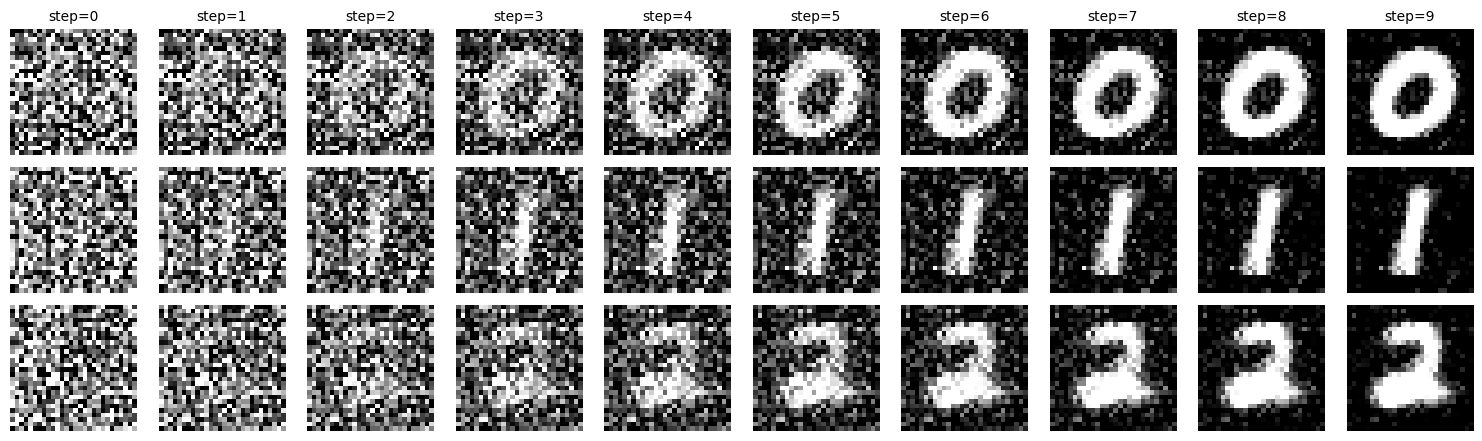

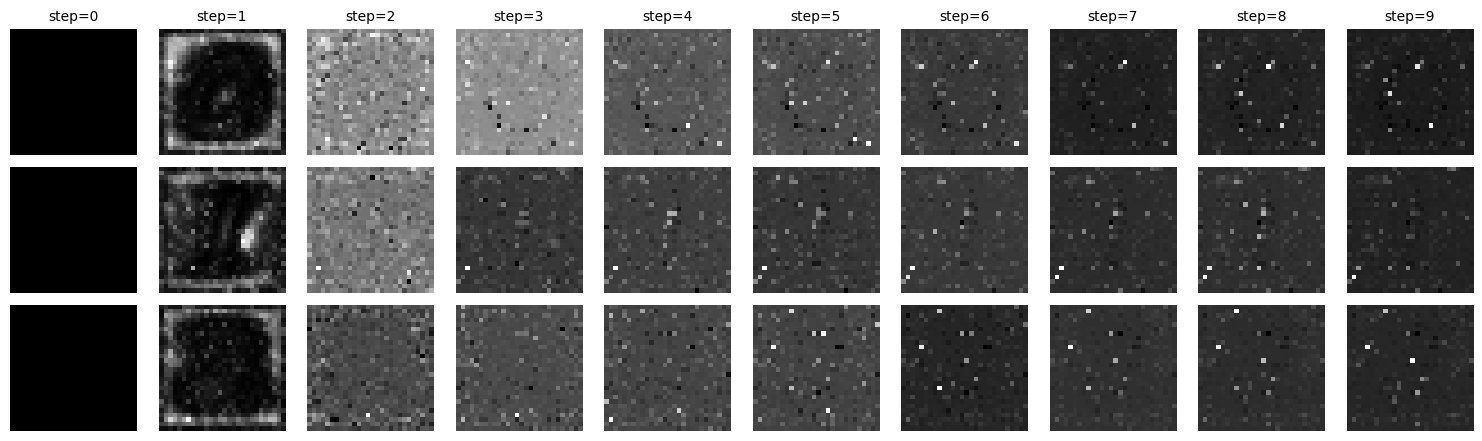

In [53]:
from PIL import Image

# NOTE: total steps and num intermediate have to match in this flow matching implementation
total_steps = 10

# Initialize uncertainty-aware diffusion (same interface as base class)
flow = UQFlowMatching(img_size=28, device=device)

all_samples_grouped, uncertainties = plot_image_uncertainty_grid(
        model=laplace_model,
        method_instance=flow,
        num_intermediate=total_steps,
        n=3,
        total_steps=total_steps,
        save_dir=save_dir,
        device=device,
        num_classes=num_classes,
        cov_num_sample=100,
    )

# Display samples grid
out_path_img = os.path.join(save_dir, "all_samples_grid.png")
display(Image.open(out_path_img))

# Display uncertainties grid
out_path_unc = os.path.join(save_dir, "all_uncertainties_grid.png")
display(Image.open(out_path_unc))


In [11]:
from src.utils.plots import plot_image_uncertainty_grid
print(uncertainties.shape)

torch.Size([10, 3, 1, 28, 28])


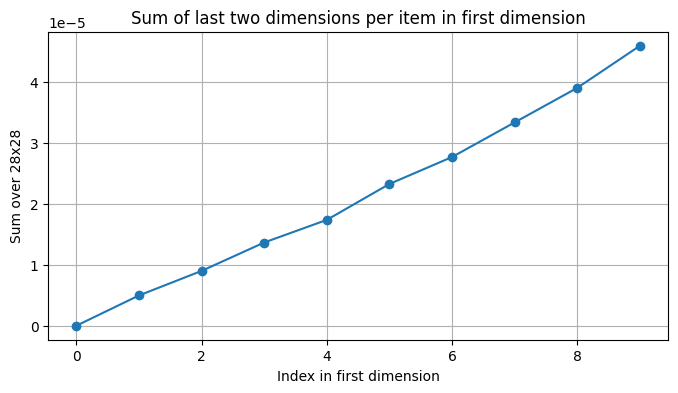

In [12]:
import torch
import matplotlib.pyplot as plt
# Sum over the last two dimensions (28x28)

# If I need to get just one of the samples
sums = uncertainties[:, 0].sum(dim=[-1, -2])  # shape: [10, 1, 1]
# sums = uncertainties.sum(dim=[-1, -2])  # shape: [10, 1, 1]

# Flatten to shape
sums_flat = sums.view(total_steps)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(range(total_steps), sums_flat.tolist(), marker='o', linestyle='-')
plt.title("Sum of last two dimensions per item in first dimension")
plt.xlabel("Index in first dimension")
plt.ylabel("Sum over 28x28")
plt.grid(True)
plt.show()